In [1]:
import numpy as np
import xarray as xr

import itertools

from src.score import *
import re
from collections import OrderedDict


In [2]:
import cartopy.crs as ccrs

In [3]:
DATADIR = '/rds/general/user/mc4117/home/WeatherBench/data/'

In [4]:
var_dict = {
        'geopotential': ('z', [500]),
        'temperature': ('t', [850])} 


ds_list = []

for long_var, params in var_dict.items():
    if long_var == 'constants':
        ds_list.append(xr.open_mfdataset(f'{DATADIR}/{long_var}/*.nc', combine='by_coords'))
    else:
        var, levels = params
        if levels is not None:
            ds_list.append(xr.open_mfdataset(f'{DATADIR}/{long_var}/*.nc', combine='by_coords').sel(level = levels))
        else:
            ds_list.append(xr.open_mfdataset(f'{DATADIR}/{long_var}/*.nc', combine='by_coords'))

# because missing first values of solar radiation exclude these from the dataset
ds_whole = xr.merge(ds_list).isel(time = slice(7, None))

In [5]:
ds_train = ds_whole.sel(time=slice('1979', '2016'))


class DataGenerator():
    def __init__(self, ds, var_dict, lead_time, batch_size=32, shuffle=True, load=True, 
                 mean=None, std=None, output_vars= None, bins_z = None):
        """
        Data generator for WeatherBench data.
        Template from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
        Args:
            ds: Dataset containing all variables
            var_dict: Dictionary of the form {'var': level}. Use None for level if data is of single level
            lead_time: Lead time in hours
            batch_size: Batch size
            shuffle: bool. If True, data is shuffled.
            load: bool. If True, datadet is loaded into RAM.
            mean: If None, compute mean from data.
            std: If None, compute standard deviation from data.
        """
        
        self.ds = ds
        self.var_dict = var_dict
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.lead_time = lead_time

        data = []
        level_names = []
        generic_level = xr.DataArray([1], coords={'level': [1]}, dims=['level'])
        for long_var, params in var_dict.items():
            if long_var == 'constants': 
                for var in params:
                    data.append(ds[var].expand_dims(
                        {'level': generic_level, 'time': ds.time}, (1, 0)
                    ))
                    level_names.append(var)
            else:
                var, levels = params
                try:
                    data.append(ds[var].sel(level=levels))
                    level_names += [f'{var}_{level}' for level in levels]
                except ValueError:
                    data.append(ds[var].expand_dims({'level': generic_level}, 1))
                    level_names.append(var)   

        self.data = xr.concat(data, 'level').transpose('time', 'lat', 'lon', 'level')
        self.data['level_names'] = xr.DataArray(
            level_names, dims=['level'], coords={'level': self.data.level})
        if output_vars is None:
            self.output_idxs = range(len(ds.data.level))
        else:
            self.output_idxs = [i for i, l in enumerate(self.data.level_names.values) 
                                if any([bool(re.match(o, l)) for o in output_vars])]

        self.bins_z = np.linspace(self.data.isel(level =self.output_idxs).min(), self.data.isel(level =self.output_idxs).max(), 100) if bins_z is None else bins_z 
        self.binned_data = xr.DataArray((np.digitize(self.data.isel(level=self.output_idxs), self.bins_z)-1)[:,:,:,0], dims=['time', 'lat', 'lon'], coords={'time':self.data.time.values, 'lat': self.data.lat.values, 'lon': self.data.lon.values})
        
        self.mean = self.data.mean(('time', 'lat', 'lon')).compute() if mean is None else mean
        self.std = self.data.std(('time', 'lat', 'lon')).compute() if std is None else std
        # Normalize
        self.data = (self.data - self.mean) / self.std
        self.n_samples = self.data.isel(time=slice(0, -lead_time)).shape[0]
        self.init_time = self.data.isel(time=slice(None, -lead_time)).time
        self.valid_time = self.data.isel(time=slice(lead_time, None)).time

        del ds
        self.on_epoch_end()

        # For some weird reason calling .load() earlier messes up the mean and std computations
        if load: print('Loading data into RAM'); self.data.load()
        if load: print('Loading data into RAM'); self.binned_data.load()            

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.ceil(self.n_samples / self.batch_size))

    def __getitem__(self, i):
        'Generate one batch of data'
        idxs = self.idxs[i * self.batch_size:(i + 1) * self.batch_size]
        X = self.data.isel(time=idxs).values
        y = self.binned_data.isel(time=idxs + self.lead_time).values
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.idxs = np.arange(self.n_samples)
        if self.shuffle == True:
            np.random.shuffle(self.idxs)



In [ ]:
bs=32
lead_time=120
output_vars = ['z_500']

# Create a training and validation data generator. Use the train mean and std for validation as well.
dg_train_120 = DataGenerator(
    ds_train.sel(time=slice('1979', '2010')), var_dict, lead_time, batch_size=bs, load=True, output_vars = output_vars)

In [14]:
ds_test = ds_whole.sel(time=slice('2017', '2018'))

In [7]:
stacked_z_results_120 = np.load('/rds/general/user/mc4117/home/WeatherBench/saved_pred_data/5_day_29_z_predictions.npy')

In [8]:
expected_value = np.dot(stacked_z_results_120, dg_train_120.bins_z)

stacked_z_120 = xr.Dataset({
    'z': xr.DataArray(
        expected_value,
        dims=['time', 'lat', 'lon'],
        coords={'time':ds_test.time[120:], 'lat': ds_test.lat, 'lon': ds_test.lon,
                })})

In [9]:
import pylab as plt
i = 0

# predicted
data = stacked_z_120.z.sel(time = '2017-10-17 ' + str(i) +':00')
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
I = data.plot(ax=ax, transform=ccrs.PlateCarree(), rasterized=True, add_colorbar=False, vmin=46500, vmax=58500)
I.set_edgecolor('face')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(I, cax =cax, label = 'Z500')
ax.set_title(''), ax.set_xticks([-150, -100, -50, 0, 50, 100, 150]); ax.set_yticks([-90, -45, 0, 45, 90]); ax.coastlines(alpha=0.5, lw=1)
plt.show()

# real
data = ds_test.z.sel(time = '2017-10-17 ' + str(i) + ':00').isel(level = 0)
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
I = data.plot(ax=ax, transform=ccrs.PlateCarree(), rasterized=True, add_colorbar=False, vmin=46500, vmax=58500)
I.set_edgecolor('face')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(I, cax =cax, label = 'Z500')
ax.set_title(''), ax.set_xticks([-150, -100, -50, 0, 50, 100, 150]); ax.set_yticks([-90, -45, 0, 45, 90]); ax.coastlines(alpha=0.5, lw=1)
plt.show()
# error
data = (stacked_z_120.z.sel(time = '2017-10-17 ' + str(i) +':00')-ds_test.z.sel(time = '2017-10-17 ' + str(i) + ':00').isel(level = 0))
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
I = data.plot(ax=ax, transform=ccrs.PlateCarree(), rasterized=True, add_colorbar=False)
I.set_edgecolor('face')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(I, cax =cax, label = 'error Z500')
ax.set_title(''), ax.set_xticks([-150, -100, -50, 0, 50, 100, 150]); ax.set_yticks([-90, -45, 0, 45, 90]); ax.coastlines(alpha=0.5, lw=1)
plt.show()


<Figure size 1000x800 with 2 Axes>

<Figure size 1000x800 with 2 Axes>

<Figure size 1000x800 with 2 Axes>

In [9]:
bs = 32
output_vars = ['z_500']
dg_train_72 = DataGenerator(
    ds_train.sel(time=slice('1979', '2010')), var_dict, lead_time = 72, batch_size=bs, load=True, output_vars = output_vars)

Loading data into RAM
Loading data into RAM


In [10]:
stacked_z_results_72 = np.load('/rds/general/user/mc4117/home/WeatherBench/saved_pred_data/3_day_29_z_predictions.npy')

In [16]:
#stacked_z_arr_72 = xr.Dataset({
#    'z': xr.DataArray(
#        stacked_z_results_72,
#        dims=['time', 'lat', 'lon', 'prob'],
#        coords={'time':ds_test.time[72:], 'lat': ds_test.lat, 'lon': ds_test.lon, 'prob': dg_train_72.bins_z
#                })})
#stacked_z_arr_72.sel(time = '2017-10').to_netcdf('/rds/general/user/mc4117/home/WeatherBench/saved_pred_data/3day_z500_oct_only.nc')

In [12]:
expected_value_72 = np.dot(stacked_z_results_72, dg_train_72.bins_z)

stacked_z_72 = xr.Dataset({
    'z': xr.DataArray(
        expected_value_72,
        dims=['time', 'lat', 'lon'],
        coords={'time':ds_test.time[72:], 'lat': ds_test.lat, 'lon': ds_test.lon,
                })})

In [13]:
data = ds_test.z.sel(time = '2017-10-17 ' + str(i) + ':00').isel(level = 0)
print(data.max().values)

58383.98


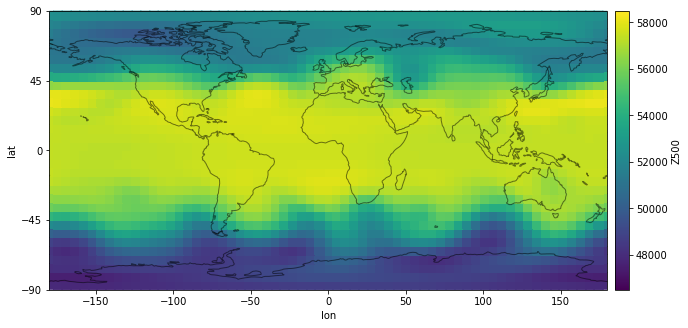

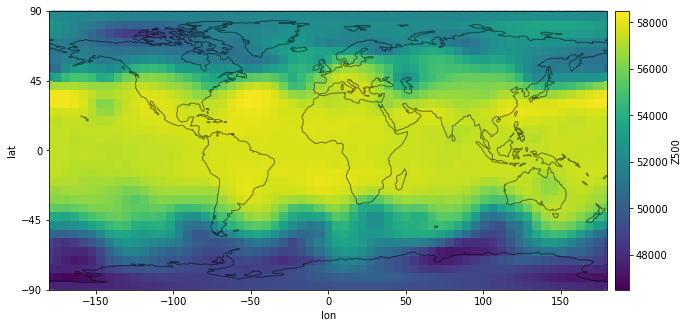

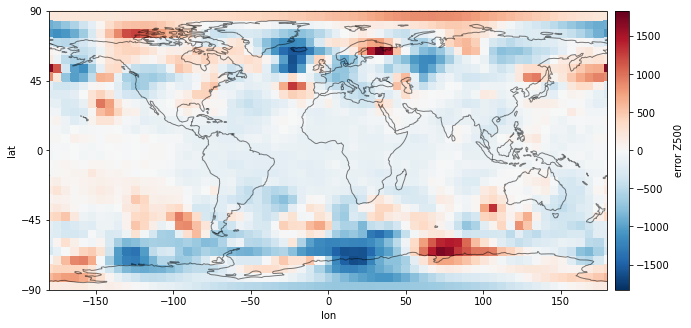

In [14]:
import pylab as plt
i = 0

# predicted
data = stacked_z_72.z.sel(time = '2017-10-17 ' + str(i) +':00')
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
I = data.plot(ax=ax, transform=ccrs.PlateCarree(), rasterized=True, add_colorbar=False, vmin=46500, vmax=58500)
I.set_edgecolor('face')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(I, cax =cax, label = 'Z500')
ax.set_title(''), ax.set_xticks([-150, -100, -50, 0, 50, 100, 150]); ax.set_yticks([-90, -45, 0, 45, 90]); ax.coastlines(alpha=0.5, lw=1)
plt.show()

# real
data = ds_test.z.sel(time = '2017-10-17 ' + str(i) + ':00').isel(level = 0)
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
I = data.plot(ax=ax, transform=ccrs.PlateCarree(), rasterized=True, add_colorbar=False, vmin=46500, vmax=58500)
I.set_edgecolor('face')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(I, cax =cax, label = 'Z500')
ax.set_title(''), ax.set_xticks([-150, -100, -50, 0, 50, 100, 150]); ax.set_yticks([-90, -45, 0, 45, 90]); ax.coastlines(alpha=0.5, lw=1)
plt.show()
# error
data = (stacked_z_72.z.sel(time = '2017-10-17 ' + str(i) +':00')-ds_test.z.sel(time = '2017-10-17 ' + str(i) + ':00').isel(level = 0))
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw={'projection': ccrs.PlateCarree()})
I = data.plot(ax=ax, transform=ccrs.PlateCarree(), rasterized=True, add_colorbar=False)
I.set_edgecolor('face')
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
plt.colorbar(I, cax =cax, label = 'error Z500')
ax.set_title(''), ax.set_xticks([-150, -100, -50, 0, 50, 100, 150]); ax.set_yticks([-90, -45, 0, 45, 90]); ax.coastlines(alpha=0.5, lw=1)
plt.show()


In [17]:
# 3 day
np.abs(stacked_z_72.z.sel(time = '2017-10-17 ' + str(i) +':00')-ds_test.z.sel(time = '2017-10-17 ' + str(i) + ':00').isel(level = 0)).mean().values

array(302.22218546)

In [18]:
# 5 day
np.abs(stacked_z_120.z.sel(time = '2017-10-17 ' + str(i) +':00')-ds_test.z.sel(time = '2017-10-17 ' + str(i) + ':00').isel(level = 0)).mean().values

array(473.56922238)